# Object Detection

In [63]:
## import required libraries 
from imageai.Detection import ObjectDetection
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
from keras.utils.data_utils import GeneratorEnqueuer

import glob
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np 
import os
import pandas as pd 

%matplotlib inline

# setup folders
image_path = "./images/"
output_dir = "./images/output"
execution_path = os.getcwd()
model_weight_path = "resnet50_coco_best_v2.0.1.h5"

# Load images and create image generator

In [2]:
batch_size = 100
img_generator = ImageDataGenerator().flow_from_directory(image_path, shuffle=False, batch_size = batch_size)
n_rounds = math.ceil(img_generator.samples / img_generator.batch_size)
filenames = img_generator.filenames

img_generator = GeneratorEnqueuer(img_generator)
img_generator.start()
img_generator = img_generator.get()

Found 11 images belonging to 2 classes.


# Map RetinaNet classes to Google object detection classes

In [4]:
# Read classes from RetinaNet. Prepared list taken from: https://github.com/fizyr/keras-retinanet/blob/master/examples/ResNet50RetinaNet.ipynb
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}
retina_classes = pd.DataFrame(list(labels_to_names.items()), columns=['ID', 'Label'])
retina_classes.head()


,ID,Label
0,0,person
1,1,bicycle
2,2,car
3,3,motorcycle
4,4,airplane


In [7]:
# Read classes from Google
google_classes = pd.read_csv("class-descriptions-boxable.csv", delimiter=";", names=['ID', 'Label'])
google_classes.head()

,ID,Label
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


In [25]:
google_classes['Label'] = google_classes['Label'].apply(str.lower)

In [26]:
google_classes

,ID,Label
0,/m/011k07,tortoise
1,/m/011q46kg,container
2,/m/012074,magpie
3,/m/0120dh,sea turtle
4,/m/01226z,football
5,/m/012n7d,ambulance
6,/m/012w5l,ladder
7,/m/012xff,toothbrush
8,/m/012ysf,syringe
9,/m/0130jx,sink


In [6]:
# Transform Google classes
google_classes_lower = google_classes['Label'].str.lower()
google_classes = pd.DataFrame([google_classes["ID"], google_classes_lower]).transpose()
google_classes.head()

,ID,Label
0,/m/011k07,tortoise
1,/m/011q46kg,container
2,/m/012074,magpie
3,/m/0120dh,sea turtle
4,/m/01226z,football


In [ ]:
# Use class key mappings for predictions

In [31]:
# Iterate over Retina_classes and check if they're in Google classes.
# If so, take google ID in new class mappings 

label_mappings = pd.DataFrame(columns=['ID', 'Label'])
coco_to_google = {}

for i in range(0, retina_classes.shape[0]):
    for j in range(0, google_classes.shape[0]):
        if(retina_classes["Label"][i] == google_classes["Label"][j]):
            label_mappings.loc[i] = google_classes.iloc[j]
            coco_to_google[retina_classes["Label"][i]] = google_classes.iloc[j]['ID']

In [33]:
# added a dictionary for easy lookup
coco_to_google

{'airplane': '/m/0cmf2',
 'apple': '/m/014j1m',
 'backpack': '/m/01940j',
 'banana': '/m/09qck',
 'baseball bat': '/m/03g8mr',
 'baseball glove': '/m/03grzl',
 'bear': '/m/01dws',
 'bed': '/m/03ssj5',
 'bench': '/m/0cvnqh',
 'bicycle': '/m/0199g',
 'bird': '/m/015p6',
 'boat': '/m/019jd',
 'book': '/m/0bt_c3',
 'bottle': '/m/04dr76w',
 'bowl': '/m/04kkgm',
 'broccoli': '/m/0hkxq',
 'bus': '/m/01bjv',
 'cake': '/m/0fszt',
 'car': '/m/0k4j',
 'carrot': '/m/0fj52s',
 'cat': '/m/01yrx',
 'chair': '/m/01mzpv',
 'clock': '/m/01x3z',
 'couch': '/m/02crq1',
 'dog': '/m/0bt9lr',
 'elephant': '/m/0bwd_0j',
 'fire hydrant': '/m/01pns0',
 'fork': '/m/0dt3t',
 'giraffe': '/m/03bk1',
 'handbag': '/m/080hkjn',
 'horse': '/m/03k3r',
 'hot dog': '/m/01b9xk',
 'kite': '/m/02zt3',
 'knife': '/m/04ctx',
 'laptop': '/m/01c648',
 'motorcycle': '/m/04_sv',
 'mouse': '/m/04rmv',
 'orange': '/m/0cyhj_',
 'oven': '/m/029bxz',
 'parking meter': '/m/015qbp',
 'person': '/m/01g317',
 'pizza': '/m/0663v',
 'refrige

# Import imageai RetinaNet model

In [34]:
from imageai.Detection import ObjectDetection
model_weight_path = "resnet50_coco_best_v2.0.1.h5"

execution_path = os.getcwd()
detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath(model_weight_path)
detector.loadModel()

# Predict single image

In [113]:
detections = detector.detectObjectsFromImage(
    input_image=os.path.join(execution_path , "./images/test/0a0a615629231821.jpg"), 
    output_image_path=os.path.join(execution_path , "./images/output/0a0a615629231821new.jpg"), 
    minimum_percentage_probability=50)

# Output detections

In [114]:
for eachObject in detections:
    print("{:<15} {:<15} {:.3f} [{}, {}, {}, {}]".format(
        eachObject["name"],
        coco_to_google[eachObject["name"]],
        eachObject["percentage_probability"],
        *eachObject["box_points"]))

handbag         /m/080hkjn      52.487 [318, 580, 378, 677]
person          /m/01g317       60.408 [277, 269, 352, 417]
person          /m/01g317       50.983 [937, 287, 1016, 448]
person          /m/01g317       53.549 [5, 274, 110, 536]
person          /m/01g317       53.045 [30, 270, 158, 513]
person          /m/01g317       80.700 [750, 233, 984, 673]
person          /m/01g317       58.238 [635, 264, 783, 672]
person          /m/01g317       71.705 [267, 348, 396, 662]
person          /m/01g317       82.736 [365, 240, 583, 669]
motorcycle      /m/04_sv        51.686 [3, 446, 178, 667]


## Transform into Output Format

In [170]:
example_submission_df = pd.read_csv('kaggle/sample_submission.csv') 

In [171]:
example_submission_df.head(1)

,ImageId,PredictionString
0,b5d912e06f74e948,/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 ...


In [172]:
example_submission_df[:1]['PredictionString'].values

array(['/m/05s2s 0.9 0.46 0.08 0.93 0.5 /m/0c9ph5 0.5 0.25 0.6 0.6 0.9'],
      dtype=object)

The submission seems to be in the following format (omit the '\['): 

`[id] [confident_score] 4x[relative floats of bounding box]`

As per official documentation the bounding box is `[xmin, ymin, xmax, ymax]`. If no prediction for an image, PredictionString should be empty.

Let's check our first results and their outputs. A visual might help:

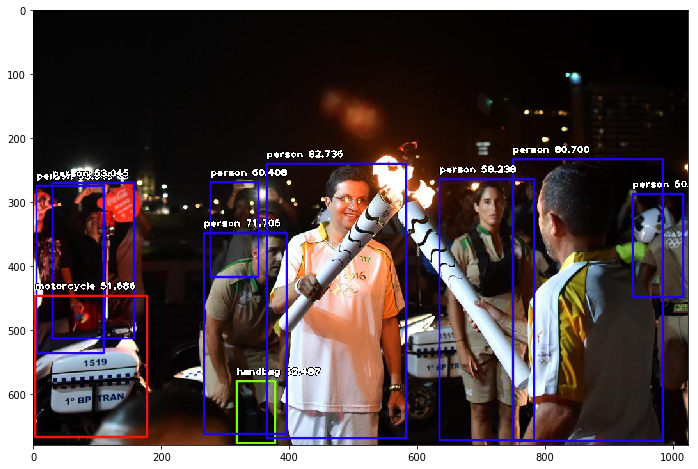

In [173]:
test_result_img = mpimg.imread('0a0a615629231821new.jpg')
fig=plt.figure(figsize=(14, 8))
_ = plt.imshow(test_result_img)

```handbag         /m/080hkjn      52.487 [318, 580, 378, 677]```

Our function returns bounding boxes in the following format: `[x1,y1,x2,y2]`. The only thing we need to do is normalize those values using image maximums for x and y.

### Negative Bounding Box Points
Some detections have negative coordinates. Those can be set to 0.0.

In [209]:
negative = os.path.join(image_path, 'test/0a0c54875010ccb1.jpg')

In [210]:
negative_img = plt.imread(negative)

In [211]:
negative_img.shape

(682, 1024, 3)

In [212]:
detections = detector.detectObjectsFromImage(
    input_image=negative_img, 
    input_type='array',
    output_image_path=os.path.join(execution_path , "./images/output/0a0c54875010ccb1new.jpg"), 
    minimum_percentage_probability=50)

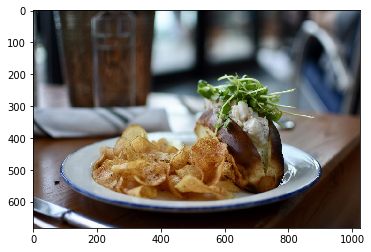

In [213]:
plt.imshow(negative_img)

In [215]:
negative_output = mpimg.imread("./images/output/0a0c54875010ccb1new.jpg")

In [214]:
detections

[{'box_points': array([ -1, 583, 230, 681]),
  'name': 'knife',
  'percentage_probability': 52.78137922286987},
 {'box_points': array([494, 193, 807, 569]),
  'name': 'sandwich',
  'percentage_probability': 62.68158555030823},
 {'box_points': array([ -17,  231, 1006,  671]),
  'name': 'dining table',
  'percentage_probability': 75.21494030952454}]

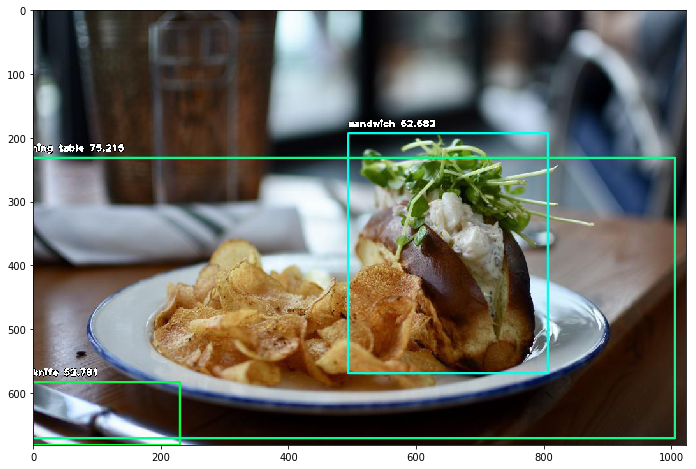

In [217]:
fig=plt.figure(figsize=(14, 8))
_ = plt.imshow(negative_output)

In [218]:
def zero_if_negative(x):
    """
    Some bounding boxes are negative. Those should be set to 0.
    """
    if x < 0:
        return 0.
    return x

### Normalize Results

In [219]:
def normalize_results(img, detection):
    # i.e. like  this
    h, w, _ = img.shape
    x1, y1, x2, y2 = detection['box_points']
    x1 /= w
    x2 /= w
    y1 /= h
    y2 /= h
    prob = detection['percentage_probability'] / 100.
    return detection['name'], prob, zero_if_negative(x1), zero_if_negative(x2), zero_if_negative(y1), zero_if_negative(y2)

In [220]:
normalize_results(test_result_img, detections[0])

('knife',
 0.5278137922286987,
 0.0,
 0.224609375,
 0.8573529411764705,
 1.0014705882352941)

In [221]:
for detection in detections:
    print ('{} {} {} {} {}'.format(
        *normalize_results(test_result_img, detection)
    ))

knife 0.5278137922286987 0.0 0.224609375 0.8573529411764705
sandwich 0.6268158555030823 0.482421875 0.7880859375 0.2838235294117647
dining table 0.7521494030952454 0.0 0.982421875 0.3397058823529412


# Combine everything

In [222]:
def extract_img_ids(fname):
    """
    Retrieves all processed images from csv file.
    This way, even if something breaks, we can pick it up wherever we started.
    
    Parameters:
    --------------
    fname: str, results file
    
    Returns:
    --------------
    ids: list, image ids that have already been processed
    """
    ids = []
    with open(fname, 'r') as f:
        for line in f.readlines()[1:]:
            if line == '\n':
                continue
            if ',' in line:
                ids.append(line.split(',')[0])
    return ids

In [228]:
def detect_objects(detector_fn, img_path, results_fname, minimum_percentage_probability, translation_dict):
    """
    Applies detector_fn to every image in img_path. 
    Retrieves only .jpg files right now.
    Write results to .csv file for submission.
    
    Parameters:
    --------------
    detector_fn:                     python function
    img_path:                        str or os.path, file of images that should be processed
    results_fname:                   str or os.path, submission file
    minimum_percentage_probabilitiy: int, filtering percentage for detector_fn
    translation_dict:                dict, maps classes to google classes
    
    Returns:
    --------------
    None
    """ 
    # initiate results file or read already processed img ids
    if not os.path.exists(results_fname):
        with open(results_fname, 'a') as f:
            f.write('ImageId,PredictionString\n')
        img_collection = []
    else:
        img_collection = extract_img_ids(results_fname)
    
    images = glob.glob(os.path.join(img_path, '*.jpg'))
    n_images = len(images)
    for ix, img_fname in enumerate(images):
        # get image id from filename
        img_id = img_fname.split('/')[-1].split('.')[0]
        if img_id in img_collection:
            continue
        print ('Working on {} ({}/{})'.format(img_id, ix+1, n_images))
        # read in data
        tmp_img = mpimg.imread(img_fname)
        # detect object per image
        tmp_detections = detector_fn(
            input_image=tmp_img, 
            input_type='array', 
            minimum_percentage_probability=minimum_percentage_probability)
        output_str = '{},'.format(img_id)
        
        # iterate over detections and transform
        for detection in tmp_detections:
            class_name, prob, x1, x2, y1, y2 = normalize_results(tmp_img, detection)
            if class_name not in translation_dict:  # class doesn't exist in google vocab
                continue
            tmp_str = "{} {} {} {} {} {} ".format(translation_dict[class_name], prob, x1, x2, y1, y2)
            output_str += tmp_str
            
        # write results to file
        with open(results_fname, 'a') as f:
            f.write(output_str.strip()) # remove last blank space
            f.write('\n')

In [224]:
detect_objects(
    detector_fn=detector.detectObjectsFromImage, 
    img_path=os.path.join(image_path, 'test'),
    results_fname='detection_test_submission.csv',
    minimum_percentage_probability=50,
    translation_dict=coco_to_google)

Working on 00a0c5ea5b4f3989 (1/5)
Working on 0a0a615629231821 (2/5)
Working on 0a0c164777da2dcf (3/5)
Working on 0a0c54875010ccb1 (4/5)
Working on 0a0f7393ed4eda8f (5/5)


In [225]:
detection_test_submission = pd.read_csv('detection_test_submission.csv')

In [226]:
detection_test_submission

,ImageId,PredictionString
0,00a0c5ea5b4f3989,/m/0k4j 0.7115340828895569 0.3681640625 0.4111...
1,0a0a615629231821,/m/080hkjn 0.524867832660675 0.310546875 0.369...
2,0a0c164777da2dcf,/m/01rkbr 0.6814230680465698 0.4501953125 0.58...
3,0a0c54875010ccb1,/m/04ctx 0.5278137922286987 0.0 0.224609375 0....
4,0a0f7393ed4eda8f,/m/01g317 0.9885817170143127 0.073206442166910...
